In [ ]:
!pip install tqdm requests beautifulsoup4

In [143]:
import time
from time import sleep

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm, trange

from collections import namedtuple
from dataclasses import dataclass

In [30]:
BASE_URL = "https://www.chitai-gorod.ru"
BEGIN_URL = f"{BASE_URL}/catalog/books/"

In [31]:
r = requests.get(BEGIN_URL)
soup = BeautifulSoup(r.text, 'lxml')

In [32]:
Genre = namedtuple("Genre", ["name", "href"])

### Определяем список жанров

In [33]:
genres_raw = soup.find_all("ul", {"class": "navigation navigation"})[1]
genres_raw = genres_raw.find_all("a", {"class": "navigation__link"})
genres_raw

[<a class="navigation__link" href="/catalog/books/khudozhestvennaya_literatura-9657/">Художественная литература</a>,
 <a class="navigation__link" href="/catalog/books/knigi_dlya_detey-9072/">Книги для детей</a>,
 <a class="navigation__link" href="/catalog/books/obrazovaniye-9405/">Образование</a>,
 <a class="navigation__link" href="/catalog/books/nauka_i_tekhnika-9170/">Наука и техника</a>,
 <a class="navigation__link" href="/catalog/books/obshchestvo-9304/">Общество</a>,
 <a class="navigation__link" href="/catalog/books/delovaya_literatura-8979/">Деловая литература</a>,
 <a class="navigation__link" href="/catalog/books/krasota_zdorovye_sport-9116/">Красота. Здоровье. Спорт</a>,
 <a class="navigation__link" href="/catalog/books/uvlecheniya-9564/">Увлечения</a>,
 <a class="navigation__link" href="/catalog/books/psikhologiya-9530/">Психология</a>,
 <a class="navigation__link" href="/catalog/books/ezoterika-9705/">Эзотерика</a>,
 <a class="navigation__link" href="/catalog/books/filosofiya

In [34]:
genres = [Genre(name=i.text, href=i['href']) for i in genres_raw if i.text]
genres

[Genre(name='Художественная литература', href='/catalog/books/khudozhestvennaya_literatura-9657/'),
 Genre(name='Книги для детей', href='/catalog/books/knigi_dlya_detey-9072/'),
 Genre(name='Образование', href='/catalog/books/obrazovaniye-9405/'),
 Genre(name='Наука и техника', href='/catalog/books/nauka_i_tekhnika-9170/'),
 Genre(name='Общество', href='/catalog/books/obshchestvo-9304/'),
 Genre(name='Деловая литература', href='/catalog/books/delovaya_literatura-8979/'),
 Genre(name='Красота. Здоровье. Спорт', href='/catalog/books/krasota_zdorovye_sport-9116/'),
 Genre(name='Увлечения', href='/catalog/books/uvlecheniya-9564/'),
 Genre(name='Психология', href='/catalog/books/psikhologiya-9530/'),
 Genre(name='Эзотерика', href='/catalog/books/ezoterika-9705/'),
 Genre(name='Философия и религия', href='/catalog/books/filosofiya_i_religiya-9645/'),
 Genre(name='Искусство', href='/catalog/books/iskusstvo-9035/'),
 Genre(name='Подарочные издания', href='/catalog/books/podarochnyye_izdaniya-9

In [269]:
# структура описания книги

@dataclass
class Book:
    title: str
    author: str
    genre: str
    annotation: str
    url: str
    publisher: str
    series: str
    year: int
    isbn: str
    pages: int
    height: float
    width: float
    thickness: float
    cover_type: str
    circulation: int # тираж
    weight: float
    age_restrictions: str
    price: int
    rating: float
    rating_count: int # количество оценок
    in_stock: bool

### Парсинг книг

Парсим отдельно книги по разным жанрам

In [270]:
# извлечение нужной информации со страницы книги
def parse_book(url: str, genre: str):
    resp = requests.get(f"{BASE_URL}/{url}")
    soup = BeautifulSoup(resp.text, "lxml")
    
    if title := soup.find("h1", {"class": "product__title js-analytic-product-title"}):
        title = title.text.strip()
    
    if author := soup.find("a", {"class": "link product__author"}):
        author = author.text.strip()
        
    if annotation := soup.find("div", {"itemprop": "description"}):
        annotation = annotation.text.strip()
    
    if publisher := soup.find("span", {"itemprop": "publisher"}):
        publisher = publisher.text
    
    if series := soup.find("span", {"itemprop": "genre"}):
        series = series.text
    else:
        series = None
        
    if year := soup.find("div", {"itemprop": "datePublished"}):
        year = int(year.text)
        
    if isbn := soup.find("span", {"itemprop": "isbn"}):
        isbn = isbn.text.strip()
    
    
    try:
        if pages := soup.find("div", {"itemprop": "numberOfPages"}):
            pages = int(pages.text.strip())
    except:
        pages = None
        
    if size := soup.find("div", text="Формат"):
        size = size.findNext("div").text.strip()
        height, width, thickness = (float(i) for i in size.split(" x "))
    else:
        height, width, thickness = (None, None, None)
    
    if cover_type := soup.find("div", text="Тип обложки"):
        cover_type = cover_type.findNext("div").text.strip()
    
    if circulation := soup.find("div", text="Тираж"):
        circulation = int(circulation.findNext("div").text.strip())
        
    if weight := soup.find("div", text="Вес, г"):
        weight = float(weight.findNext("div").text.strip())
    
    if age_restrictions := soup.find("div", text="Возрастные ограничения"):
        age_restrictions = age_restrictions.findNext("div").text.strip()
    
    
    if price := soup.find("div", {"class": "price"}):
        price = price.text.replace("₽", "")
    
    try:
        rating = float(soup.find("span", {"class": "js__rating_count"}).text)
        rating_count = int(soup.find("span", {"class": "star-rating__text js__star_rating_text"}).text.split()[0])
    except:
        rating = 0.0
        rating_count = 0
    
    if in_stock := soup.find("span", {"class": "quantity__text"}):
        in_stock = in_stock.text == "В наличии"
    else:
        in_stock = False
    
    book = Book(
        url=url,
        title=title,
        genre=genre,
        author=author,
        annotation=annotation,
        publisher=publisher,
        series=series,
        year=year,
        isbn=isbn,
        pages=pages,
        height=height,
        width=width,
        thickness=thickness,
        cover_type=cover_type,
        circulation=circulation,
        weight=weight,
        age_restrictions=age_restrictions,
        price=price,
        rating=rating,
        rating_count=rating_count,
        in_stock=in_stock
    )
    return book


# пасринг книг заданного жанра
def parse_genre(genre: Genre, page=1):
    print(f"\tПарсинг страницы {page}")
    
    r = requests.get(f"{BASE_URL}/{genre.href}/?page={page}")
    soup = BeautifulSoup(r.text, "lxml")
    books = soup.find_all("div", {"class": "product-card__info"})
    books_urls = [i.find("a", {"class": "product-card__link"})["href"] for i in books]
    
    # берем максиммум 50 первых страниц из списка книг
    num_of_pages = min(50, int(soup.find_all("a", {"class": "pagination-item"})[-2].text))
    
    
    for url in books_urls:
        book = parse_book(url, genre)
        yield book
    
    if page < num_of_pages:
        for book in parse_genre(genre=genre, page=page+1):
            yield book


In [ ]:
books = []
for genre in genres:
    print(f"Парсинг жанра {genre.name}")
    for book in parse_genre(genre):
        books.append(book)

In [166]:
import pandas as pd

In [183]:
df = pd.DataFrame(books)
df

,title,author,genre,annotation,url,publisher,series,year,isbn,pages,...,width,thickness,cover_type,circulation,weight,age_restrictions,price,rating,rating_count,in_stock
0,Каменное сердце,К.Дж. Сэнсом,"(Художественная литература, /catalog/books/khu...",Лето 1545 года. Франция стягивает армаду своих...,/catalog/book/2915753/,Азбука,The Big Book,2022.0,978-5-389-21286-2,800.0,...,11.5,3.0,Мягкая глянцевая,5000.0,370.0,16+,267,5.0,1,True
1,Однажды ночью в августе,Виктория Хислоп,"(Художественная литература, /catalog/books/khu...","Спустя пятнадцать лет после того, как увидел с...",/catalog/book/2915752/,Азбука,The Big Book,2022.0,978-5-389-21284-8,384.0,...,11.5,1.5,Мягкая глянцевая,5000.0,180.0,16+,193,0.0,0,True
2,Стамбульский бастард,Элиф Шафак,"(Художественная литература, /catalog/books/khu...",Роман «Стамбульский бастард» представляет исто...,/catalog/book/2915751/,Азбука,The Big Book,2022.0,978-5-389-21285-5,448.0,...,11.5,1.7,Мягкая глянцевая,5000.0,210.0,16+,193,0.0,0,True
3,Сюзанна,Бузлуков П.,"(Художественная литература, /catalog/books/khu...","Пусть родилась я не поэтом,\r\n— Пусть торгашо...",/catalog/book/2915731/,Де''Либри,None,2022.0,978-5-4491-1387-0,664.0,...,15.3,4.0,Твердая глянцевая,NaN,920.0,16+,403,0.0,0,False
4,Мертвое царство,Андрианова А.,"(Художественная литература, /catalog/books/khu...","Ивель — падальщица, бунтующая дочь из обеспече...",/catalog/book/2915730/,Animedia Company,Сказания Арконы,2022.0,978-80-7499-465-4,350.0,...,15.3,2.0,Твердая глянцевая,NaN,470.0,18+,1324,5.0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17199,Маркетинг без бюджета (с автографом),Манн И.,"(Книги с автографом, /catalog/books/knigi_s_av...",Идея написать книгу о маркетинге (почти или со...,/catalog/book/2901460/,"Манн, Иванов и Фербер",None,2020.0,None,288.0,...,17.3,3.0,None,NaN,620.0,16+,None,3.5,2,False
17200,Гастро-книга: Пищеварение вдоль и поперек (с а...,Вялов С.,"(Книги с автографом, /catalog/books/knigi_s_av...",Перед вами не учебник для врачей и не инструкц...,/catalog/book/2901459/,АСТ,Достоверная медицина,2020.0,None,304.0,...,14.5,2.0,None,NaN,420.0,12+,725,3.5,4,False
17201,Карнавал лжи (с автографом),Сафонова Е.С.,"(Книги с автографом, /catalog/books/knigi_s_av...",Полгода. Всего полгода спокойной жизни — столь...,/catalog/book/2901455/,Эксмо,None,2022.0,None,512.0,...,14.9,2.8,None,NaN,510.0,16+,625,5.0,3,False
17202,Когда завтра настанет вновь (с автографом),Сафонова Е.С.,"(Книги с автографом, /catalog/books/knigi_s_av...","В мире, где магия давно стала обыденностью и и...",/catalog/book/2901454/,Эксмо,None,2021.0,None,544.0,...,13.1,2.6,None,NaN,450.0,16+,575,5.0,3,False


In [194]:
df['genre_name'] = df['genre'].apply(lambda x: x[0])
df['genre_url'] = df['genre'].apply(lambda x: x[1])

df.drop(["genre"], axis=1, inplace=True)

In [189]:
df['price'] = pd.to_numeric(df['price'])

In [196]:
df.to_csv("ch_books.csv", index=False)

In [197]:
df = pd.read_csv("ch_books.csv")
df.head()

,title,author,annotation,url,publisher,series,year,isbn,pages,height,...,cover_type,circulation,weight,age_restrictions,price,rating,rating_count,in_stock,genre_name,genre_url
0,Каменное сердце,К.Дж. Сэнсом,Лето 1545 года. Франция стягивает армаду своих...,/catalog/book/2915753/,Азбука,The Big Book,2022.0,978-5-389-21286-2,800.0,18.0,...,Мягкая глянцевая,5000.0,370.0,16+,267.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
1,Однажды ночью в августе,Виктория Хислоп,"Спустя пятнадцать лет после того, как увидел с...",/catalog/book/2915752/,Азбука,The Big Book,2022.0,978-5-389-21284-8,384.0,18.0,...,Мягкая глянцевая,5000.0,180.0,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
2,Стамбульский бастард,Элиф Шафак,Роман «Стамбульский бастард» представляет исто...,/catalog/book/2915751/,Азбука,The Big Book,2022.0,978-5-389-21285-5,448.0,18.0,...,Мягкая глянцевая,5000.0,210.0,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
3,Сюзанна,Бузлуков П.,"Пусть родилась я не поэтом,\r\n— Пусть торгашо...",/catalog/book/2915731/,Де''Либри,NaN,2022.0,978-5-4491-1387-0,664.0,21.7,...,Твердая глянцевая,NaN,920.0,16+,403.0,0.0,0,False,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
4,Мертвое царство,Андрианова А.,"Ивель — падальщица, бунтующая дочь из обеспече...",/catalog/book/2915730/,Animedia Company,Сказания Арконы,2022.0,978-80-7499-465-4,350.0,21.7,...,Твердая глянцевая,NaN,470.0,18+,1324.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/


# Исследование данных

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Выбросы

> Книга изданная в 3000 году!

In [234]:
df[df['year'] == df['year'].max()]

,title,author,annotation,url,publisher,series,year,isbn,pages,height,...,cover_type,circulation,weight,age_restrictions,price,rating,rating_count,in_stock,genre_name,genre_url
2342,Первоклассные смешинки,Ирина Гурина,Жизнь первоклассника Дениса наполнена забавным...,/catalog/book/2903096/,Феникс-Премьер,Школа по приколу,3000.0,978-5-222-37637-9,111.0,23.5,...,Твердая бумажная,NaN,350.0,0+,730.0,0.0,0,True,Книги для детей,/catalog/books/knigi_dlya_detey-9072/


Удалим все книги, "вышедшие" после 2022 года.

In [244]:
df = df[df['year'] <= 2022]

> Самая тяжелая книга весит 616 кг.? Опять ошибка

In [245]:
df[df['weight'] == df['weight'].max()][['title', 'weight']]

,title,weight
12338,Финляндская Православная Церковь в 1957-1988 г...,616000.0


In [246]:
df = df[df['weight'] != df['weight'].max()]

### Самые "дорогие" жанры

Подарочные издания, как и ожидается, входит в топ самых дорогих категорий товаров  
Образование и книги для детей - самые дешевые

In [247]:
df.groupby("genre_name")['price'].mean().sort_values(ascending=False)

genre_name
Подарочные издания             4964.091137
Эзотерика                      1337.004181
Наука и техника                1318.661358
Искусство                      1149.658027
Деловая литература             1051.949875
Общество                        957.904641
Увлечения                       946.407065
Книги на иностранных языках     922.570117
Психология                      846.625105
Философия и религия             810.966499
Книги с автографом              801.431734
Красота. Здоровье. Спорт        776.757322
Художественная литература       714.461153
Книги для детей                 462.654971
Образование                     404.204766
Name: price, dtype: float64

In [248]:
df.groupby('author').size().sort_values(ascending=False)

author
Горохова Ю. (ред.)                                                                                      38
Всеволод Костров                                                                                        30
В.В. Кузнецова                                                                                          29
Донцова Д.                                                                                              29
Фасхутдинов Р. (ред.)                                                                                   26
                                                                                                        ..
Игорь Долбышев                                                                                           1
Игорь Кожевников                                                                                         1
Игорь Лисов                                                                                              1
Абдуллаева Ольга Баходыровна, 

In [249]:
df.groupby('publisher').size().sort_values(ascending=False)

publisher
АСТ                        1844
Эксмо                      1478
Бомбора                     574
Лань                        302
Проспект                    278
                           ... 
Аверсэв                       1
Авиалогистика                 1
Аврора (СПб.)                 1
МТО Инфо                      1
Издатель Цимберов Р. М.       1
Length: 1189, dtype: int64

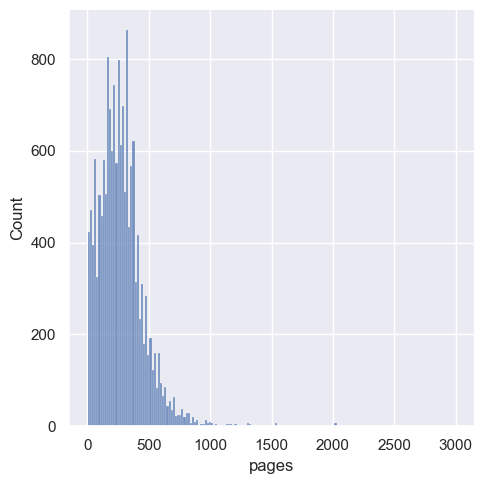

In [261]:
sns.displot(df['pages'])

Пользователи магазина "Читай-город" очень охотно ставят книгам максимальную оценку

<AxesSubplot:xlabel='rating', ylabel='Count'>

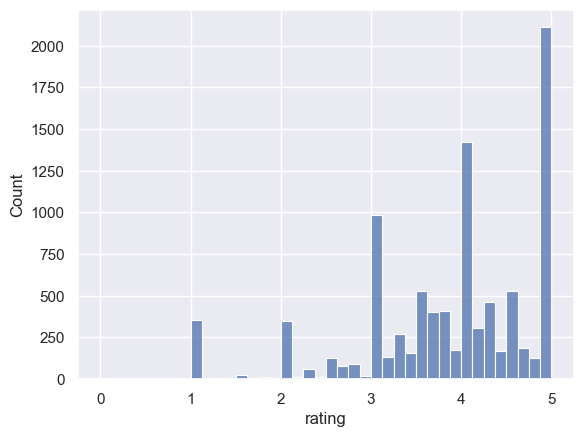

In [251]:
sns.histplot(df[df['rating_count'] != 0]['rating'])

> Ожидаемо, цена книги зависит от ее веса и количества страниц

<AxesSubplot:xlabel='weight', ylabel='price'>

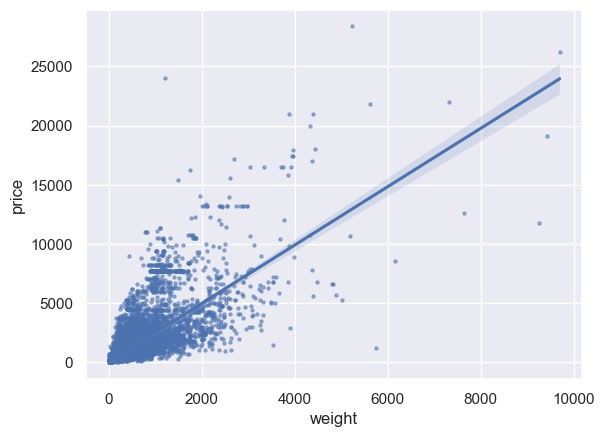

In [260]:
sns.regplot(data=df, x='weight', y='price', scatter_kws={'s': 5, 'alpha': 0.5})

<AxesSubplot:xlabel='pages', ylabel='price'>

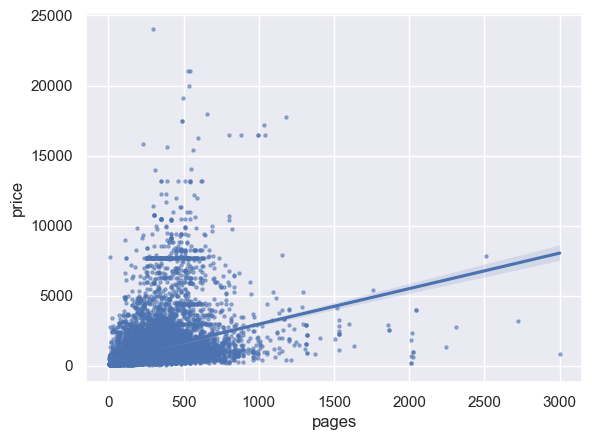

In [268]:
sns.regplot(data=df, x='pages', y='price', scatter_kws={'s': 5, 'alpha': 0.5})

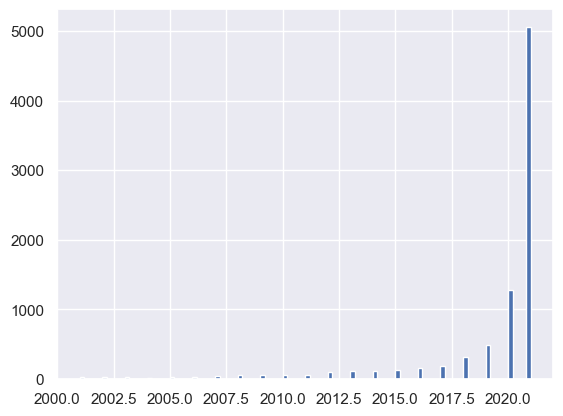

In [237]:
plt.hist(df[(df['year'] < 2022) & (df['year'] > 2000)]['year'], bins=100);

# Работаем с cvs файл

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### title (название):
Название книги.
#### author (автор):
Имя автора книги.
#### annotation (аннотация):
Краткое описание содержания книги.
#### url (URL):
Ссылка на страницу с подробной информацией о книге.
#### publisher (издательство):
Издательство, выпустившее книгу.
#### series (серия):
Серия, к которой принадлежит книга (если применимо).
#### year (год):
Год издания книги.
#### isbn (ISBN):
Международный стандартный номер книги.
#### pages (количество страниц):
Количество страниц в книге.
#### height (высота):
Высота книги в сантиметрах.
#### cover_type (тип обложки):
Тип обложки книги (мягкая, твердая и т.д.).
#### circulation (тираж):
Тираж книги (количество экземпляров, выпущенных в продажу).
#### weight (вес):
Вес книги в граммах.
#### age_restrictions (возрастные ограничения):
Возрастные ограничения для чтения книги.
#### price (цена):
Цена книги.
#### rating (рейтинг):
Рейтинг книги (если имеется).
#### rating_count (количество оценок):
Количество оценок, полученных книгой.
#### in_stock (в наличии):
Флаг, указывающий, доступна ли книга в настоящее время.
#### genre_name (название жанра):
Название жанра, к которому принадлежит книга.
#### genre_url (URL жанра):
Ссылка на страницу с книгами данного жанра.

In [3]:
df = pd.read_csv('ch_book_veronika.csv')
df

,title,author,annotation,url,publisher,series,year,isbn,pages,height,...,cover_type,circulation,weight,age_restrictions,price,rating,rating_count,in_stock,genre_name,genre_url
0,Каменное сердце,К.Дж. Сэнсом,Лето 1545 года. Франция стягивает армаду своих...,/catalog/book/2915753/,Азбука,The Big Book,2022.0,978-5-389-21286-2,800.0,18.0,...,Мягкая глянцевая,5000.0,370.0,16+,267.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
1,Однажды ночью в августе,Виктория Хислоп,"Спустя пятнадцать лет после того, как увидел с...",/catalog/book/2915752/,Азбука,The Big Book,2022.0,978-5-389-21284-8,384.0,18.0,...,Мягкая глянцевая,5000.0,180.0,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
2,Стамбульский бастард,Элиф Шафак,Роман «Стамбульский бастард» представляет исто...,/catalog/book/2915751/,Азбука,The Big Book,2022.0,978-5-389-21285-5,448.0,18.0,...,Мягкая глянцевая,5000.0,210.0,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
3,Сюзанна,Бузлуков П.,"Пусть родилась я не поэтом,\r\n— Пусть торгашо...",/catalog/book/2915731/,Де''Либри,NaN,2022.0,978-5-4491-1387-0,664.0,21.7,...,Твердая глянцевая,NaN,920.0,16+,403.0,0.0,0,False,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
4,Мертвое царство,Андрианова А.,"Ивель — падальщица, бунтующая дочь из обеспече...",/catalog/book/2915730/,Animedia Company,Сказания Арконы,2022.0,978-80-7499-465-4,350.0,21.7,...,Твердая глянцевая,NaN,470.0,18+,1324.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17199,Маркетинг без бюджета (с автографом),Манн И.,Идея написать книгу о маркетинге (почти или со...,/catalog/book/2901460/,"Манн, Иванов и Фербер",NaN,2020.0,NaN,288.0,24.0,...,NaN,NaN,620.0,16+,NaN,3.5,2,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/
17200,Гастро-книга: Пищеварение вдоль и поперек (с а...,Вялов С.,Перед вами не учебник для врачей и не инструкц...,/catalog/book/2901459/,АСТ,Достоверная медицина,2020.0,NaN,304.0,22.0,...,NaN,NaN,420.0,12+,725.0,3.5,4,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/
17201,Карнавал лжи (с автографом),Сафонова Е.С.,Полгода. Всего полгода спокойной жизни — столь...,/catalog/book/2901455/,Эксмо,NaN,2022.0,NaN,512.0,22.5,...,NaN,NaN,510.0,16+,625.0,5.0,3,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/
17202,Когда завтра настанет вновь (с автографом),Сафонова Е.С.,"В мире, где магия давно стала обыденностью и и...",/catalog/book/2901454/,Эксмо,NaN,2021.0,NaN,544.0,20.6,...,NaN,NaN,450.0,16+,575.0,5.0,3,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/


In [4]:
df.isna().sum()

title                  1
author               718
annotation             2
url                    0
publisher            106
series              8118
year                 110
isbn                 654
pages                898
height               219
width                219
thickness            219
cover_type          1328
circulation         5152
weight               542
age_restrictions    7430
price                 99
rating                 0
rating_count           0
in_stock               0
genre_name             0
genre_url              0
dtype: int64

исходя из предоставленных данных о количестве пропущенных значений в каждом столбце, вот обработка пропущенных значений для каждого столбца:

##### title: 
Пропущенное значение одно, можно удалить строку с пропущенным значением.
##### author: 
718 пропущенных значений. Можно заполнить их значением "Unknown".
##### annotation: 
2 пропущенных значения. Если аннотация является обязательным полем, можно удалить строки с пропущенными значениями.
##### url: 
Нет пропущенных значений.
##### publisher: 
106 пропущенных значений. Можно заполнить их значением "Unknown".
##### series: 
8118 пропущенных значений.
##### year: 
110 пропущенных значений. Можно заполнить их средним значением года издания.
##### isbn: 
654 пропущенных значения.
##### pages: 
898 пропущенных значений. Можно заполнить их средним значением количества страниц.
##### height, width, thickness: 
219 пропущенных значений для каждого столбца. Можно заполнить их средними значениями для соответствующих размеров.
##### cover_type: 
1328 пропущенных значений.
##### circulation:
5152 пропущенных значений.
##### weight: 
542 пропущенных значения. Можно заполнить их средним значением веса.
##### age_restrictions: 
7430 пропущенных значений.
##### price:
99 пропущенных значений. Можно заполнить их средним значением цены.


#### Исходя из этой информации, использовал методы fillna() и dropna() для обработки пропущенных значений в каждом столбце.

In [6]:
data = pd.read_csv('ch_book_veronika.csv')
data = data.dropna(subset=['title'])
data['author'] = data['author'].fillna('Unknown')
data = data.dropna(subset=['annotation'])
data['publisher'] = data['publisher'].fillna('Unknown')
data['series'] = data['series'].fillna('')
data['year'] = data['year'].fillna(data['year'].mean())
data = data.dropna(subset=['isbn', 'circulation'])

numeric_columns = ['pages', 'height', 'width', 'thickness', 'weight', 'price']
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

categorical_columns = ['cover_type', 'age_restrictions']
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

missing_values_after = data.isnull().sum()
print("Пропущенные значения после обработки:\n", missing_values_after)

Пропущенные значения после обработки:
 title               0
author              0
annotation          0
url                 0
publisher           0
series              0
year                0
isbn                0
pages               0
height              0
width               0
thickness           0
cover_type          0
circulation         0
weight              0
age_restrictions    0
price               0
rating              0
rating_count        0
in_stock            0
genre_name          0
genre_url           0
dtype: int64


# Визуализация данных:

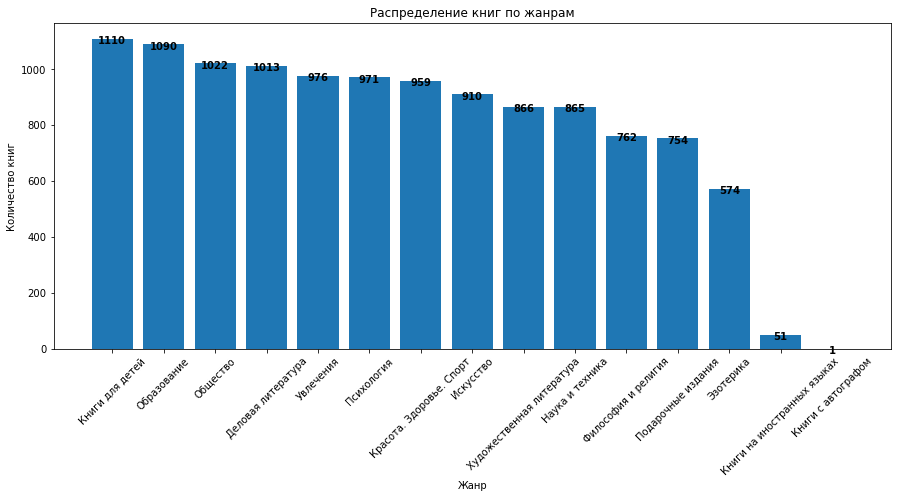

In [7]:
genre_counts = data['genre_name'].value_counts()

plt.figure(figsize=(15, 6))
plt.bar(genre_counts.index, genre_counts.values)
plt.xlabel('Жанр')
plt.ylabel('Количество книг')
plt.title('Распределение книг по жанрам')
plt.xticks(rotation=45)

for i, v in enumerate(genre_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='top', fontweight='bold')

plt.show()


На графике видно, что книги образовательного жанра и литература для детей занимают лидирующие позиции с небольшим отрывом. Однако в целом, различия в количестве книг по жанрам незначительны.

## Найдем соотношение типов обложек

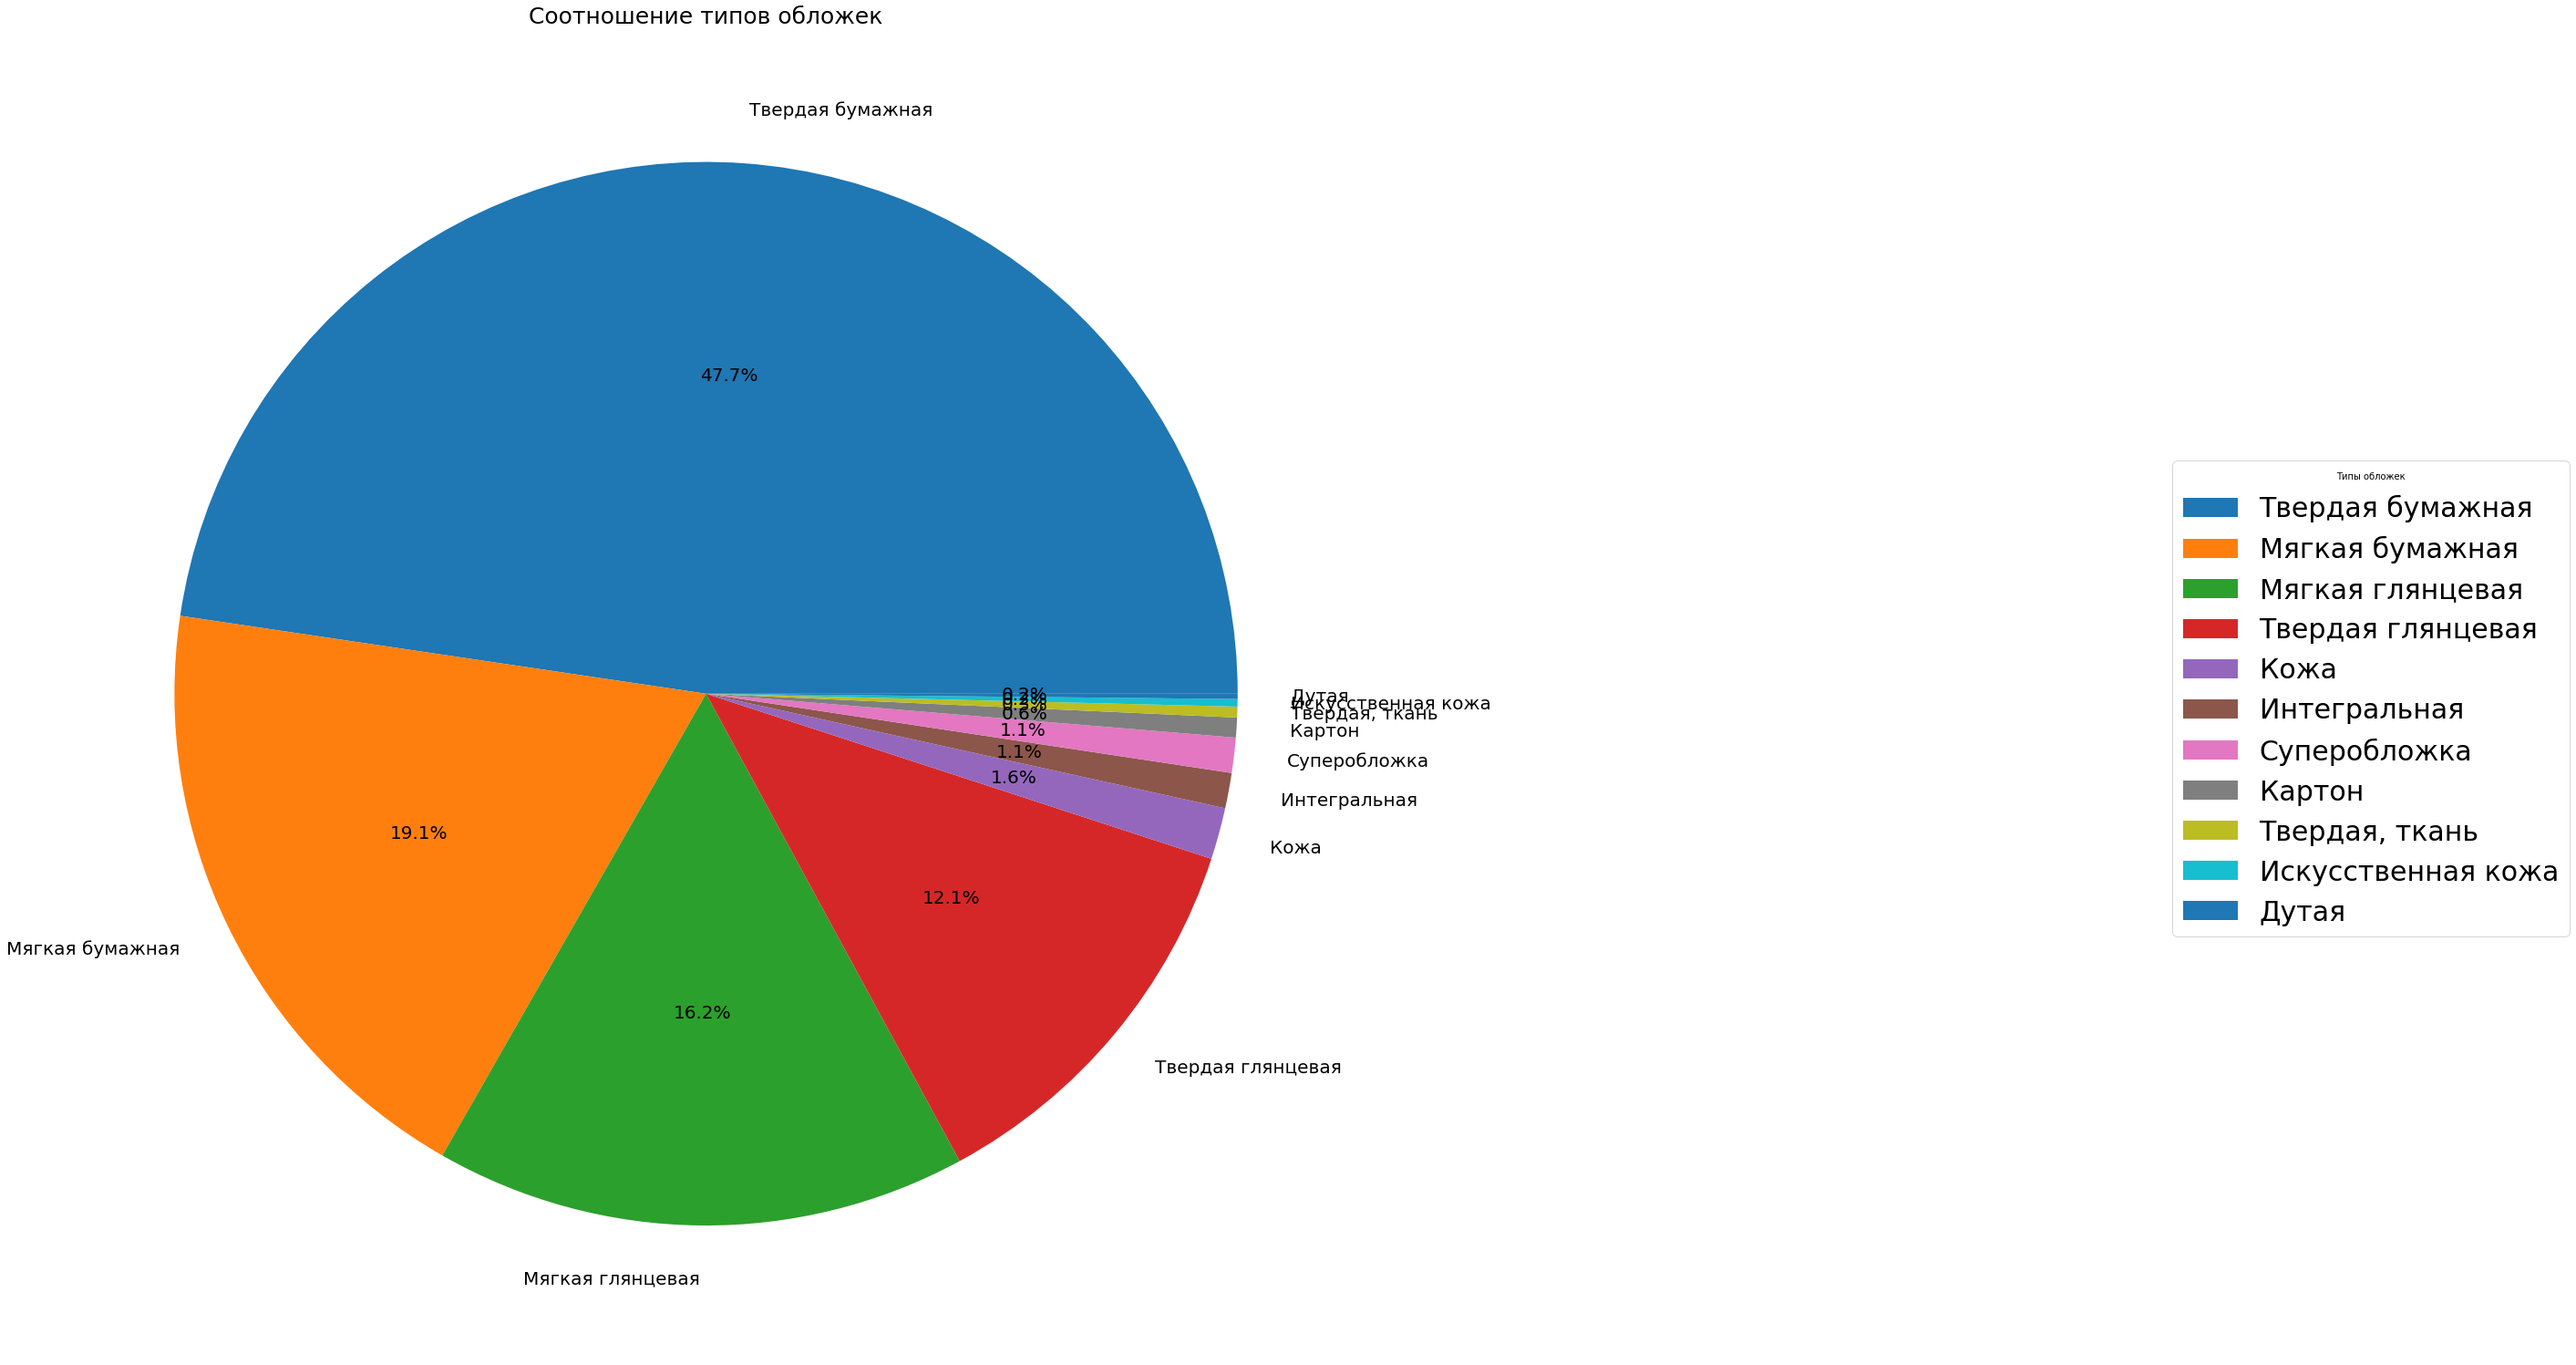

In [8]:
cover_type_counts = data['cover_type'].value_counts()

plt.figure(figsize=(30, 30))
plt.pie(cover_type_counts.values, labels=cover_type_counts.index, autopct='%1.1f%%', textprops={'fontsize': 20})
plt.title('Соотношение типов обложек', fontsize=25)
legend = plt.legend(title='Типы обложек', loc='center left', bbox_to_anchor=(1.2, 0.5), bbox_transform=plt.gcf().transFigure, fontsize=30)
plt.subplots_adjust(right=0.8)
plt.show()


In [9]:
cover_type_counts = data['cover_type'].value_counts()
total_books = len(data['cover_type'])
percentages = [(count / total_books) * 100 for count in cover_type_counts.values]

types_and_percentages = list(zip(cover_type_counts.index, percentages))

for cover_type, percentage in types_and_percentages:
    print(f"{cover_type}: {percentage:.1f}%")


Твердая бумажная: 47.7%
Мягкая бумажная: 19.1%
Мягкая глянцевая: 16.2%
Твердая глянцевая: 12.1%
Кожа: 1.6%
Интегральная: 1.1%
Суперобложка: 1.1%
Картон: 0.6%
Твердая, ткань: 0.3%
Искусственная кожа: 0.2%
Дутая: 0.2%


Самым востребованным типом обложки является твердая бумажная обложка, которая составляет почти половину всех книг в выборке (47,7%). Это свидетельствует о том, что многие читатели предпочитают книги с более прочной обложкой. Другие типы обложек, такие как твердая глянцевая, кожаная, интегральная, суперобложка, картонная, твердая тканевая и искусственная кожа, составляют лишь 16,0% от общего числа книг. Это может свидетельствовать об их более узкой нише или ограниченной популярности среди читателей.

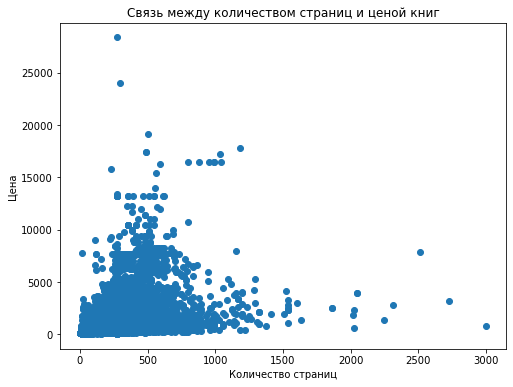

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(data['pages'], data['price'])
plt.xlabel('Количество страниц')
plt.ylabel('Цена')
plt.title('Связь между количеством страниц и ценой книг')
plt.show()


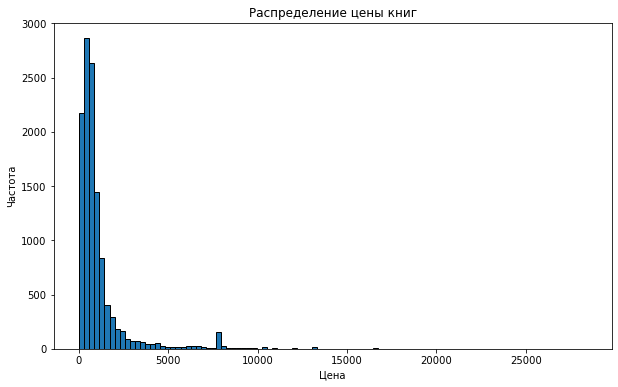

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(data['price'], bins=100, edgecolor='black')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title('Распределение цены книг')
plt.show()

Из графика можно сделать вывод что в основном большое количество книг стоят менше чем примерно 2500 рублей.

# Создание новых признаков

### 1. Коэффициент влияния рейтинга:

 Количество оценок, умноженное на рейтинг. Это может помочь определить, какие книги имеют наибольшее влияние с точки зрения обратной связи от пользователей.

In [12]:
df['rating_influence'] = df['rating'] * df['rating_count'] # Создаем новый столбец "rating_influence"
df

,title,author,annotation,url,publisher,series,year,isbn,pages,height,...,circulation,weight,age_restrictions,price,rating,rating_count,in_stock,genre_name,genre_url,rating_influence
0,Каменное сердце,К.Дж. Сэнсом,Лето 1545 года. Франция стягивает армаду своих...,/catalog/book/2915753/,Азбука,The Big Book,2022.0,978-5-389-21286-2,800.0,18.0,...,5000.0,370.0,16+,267.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,5.0
1,Однажды ночью в августе,Виктория Хислоп,"Спустя пятнадцать лет после того, как увидел с...",/catalog/book/2915752/,Азбука,The Big Book,2022.0,978-5-389-21284-8,384.0,18.0,...,5000.0,180.0,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0
2,Стамбульский бастард,Элиф Шафак,Роман «Стамбульский бастард» представляет исто...,/catalog/book/2915751/,Азбука,The Big Book,2022.0,978-5-389-21285-5,448.0,18.0,...,5000.0,210.0,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0
3,Сюзанна,Бузлуков П.,"Пусть родилась я не поэтом,\r\n— Пусть торгашо...",/catalog/book/2915731/,Де''Либри,NaN,2022.0,978-5-4491-1387-0,664.0,21.7,...,NaN,920.0,16+,403.0,0.0,0,False,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0
4,Мертвое царство,Андрианова А.,"Ивель — падальщица, бунтующая дочь из обеспече...",/catalog/book/2915730/,Animedia Company,Сказания Арконы,2022.0,978-80-7499-465-4,350.0,21.7,...,NaN,470.0,18+,1324.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17199,Маркетинг без бюджета (с автографом),Манн И.,Идея написать книгу о маркетинге (почти или со...,/catalog/book/2901460/,"Манн, Иванов и Фербер",NaN,2020.0,NaN,288.0,24.0,...,NaN,620.0,16+,NaN,3.5,2,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,7.0
17200,Гастро-книга: Пищеварение вдоль и поперек (с а...,Вялов С.,Перед вами не учебник для врачей и не инструкц...,/catalog/book/2901459/,АСТ,Достоверная медицина,2020.0,NaN,304.0,22.0,...,NaN,420.0,12+,725.0,3.5,4,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,14.0
17201,Карнавал лжи (с автографом),Сафонова Е.С.,Полгода. Всего полгода спокойной жизни — столь...,/catalog/book/2901455/,Эксмо,NaN,2022.0,NaN,512.0,22.5,...,NaN,510.0,16+,625.0,5.0,3,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,15.0
17202,Когда завтра настанет вновь (с автографом),Сафонова Е.С.,"В мире, где магия давно стала обыденностью и и...",/catalog/book/2901454/,Эксмо,NaN,2021.0,NaN,544.0,20.6,...,NaN,450.0,16+,575.0,5.0,3,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,15.0


В нашем наборе данных появился новый показатель, который объединяет рейтинг книги и количество оценок, полученных ею от пользователей. Этот показатель может быть полезен при оценке общего влияния книги, основанного на пользовательских рейтингах.

### 2. Плотность текста:

Количество страниц, деленное на вес. Это может показать, насколько "плотным" является текст книги.

In [13]:
df['density'] = df['weight'] / df['pages'] # Создаем новый столбец "density"
df

,title,author,annotation,url,publisher,series,year,isbn,pages,height,...,weight,age_restrictions,price,rating,rating_count,in_stock,genre_name,genre_url,rating_influence,density
0,Каменное сердце,К.Дж. Сэнсом,Лето 1545 года. Франция стягивает армаду своих...,/catalog/book/2915753/,Азбука,The Big Book,2022.0,978-5-389-21286-2,800.0,18.0,...,370.0,16+,267.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,5.0,0.462500
1,Однажды ночью в августе,Виктория Хислоп,"Спустя пятнадцать лет после того, как увидел с...",/catalog/book/2915752/,Азбука,The Big Book,2022.0,978-5-389-21284-8,384.0,18.0,...,180.0,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0,0.468750
2,Стамбульский бастард,Элиф Шафак,Роман «Стамбульский бастард» представляет исто...,/catalog/book/2915751/,Азбука,The Big Book,2022.0,978-5-389-21285-5,448.0,18.0,...,210.0,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0,0.468750
3,Сюзанна,Бузлуков П.,"Пусть родилась я не поэтом,\r\n— Пусть торгашо...",/catalog/book/2915731/,Де''Либри,NaN,2022.0,978-5-4491-1387-0,664.0,21.7,...,920.0,16+,403.0,0.0,0,False,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0,1.385542
4,Мертвое царство,Андрианова А.,"Ивель — падальщица, бунтующая дочь из обеспече...",/catalog/book/2915730/,Animedia Company,Сказания Арконы,2022.0,978-80-7499-465-4,350.0,21.7,...,470.0,18+,1324.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,5.0,1.342857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17199,Маркетинг без бюджета (с автографом),Манн И.,Идея написать книгу о маркетинге (почти или со...,/catalog/book/2901460/,"Манн, Иванов и Фербер",NaN,2020.0,NaN,288.0,24.0,...,620.0,16+,NaN,3.5,2,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,7.0,2.152778
17200,Гастро-книга: Пищеварение вдоль и поперек (с а...,Вялов С.,Перед вами не учебник для врачей и не инструкц...,/catalog/book/2901459/,АСТ,Достоверная медицина,2020.0,NaN,304.0,22.0,...,420.0,12+,725.0,3.5,4,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,14.0,1.381579
17201,Карнавал лжи (с автографом),Сафонова Е.С.,Полгода. Всего полгода спокойной жизни — столь...,/catalog/book/2901455/,Эксмо,NaN,2022.0,NaN,512.0,22.5,...,510.0,16+,625.0,5.0,3,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,15.0,0.996094
17202,Когда завтра настанет вновь (с автографом),Сафонова Е.С.,"В мире, где магия давно стала обыденностью и и...",/catalog/book/2901454/,Эксмо,NaN,2021.0,NaN,544.0,20.6,...,450.0,16+,575.0,5.0,3,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,15.0,0.827206


Создание такого показателя может оказаться полезным для анализа данных, особенно если мы хотим исследовать, как отношение веса книги к количеству страниц влияет на другие параметры, такие как рейтинг. Книги с большей 'плотностью' могут быть сложнее для чтения из-за мелкого шрифта или тонкой бумаги, что может сказаться на их рейтинге.

### 3. Ожидаемая доступность:

Если книга доступна, но тираж ограничен, она может скоро закончиться. Мы можем создать показатель, указывающий на количество оставшихся книг, исходя из тиража и статуса 'в наличии'. Для создания показателя 'availability_score', основанного на цене и наличии, можно присвоить каждой книге оценку от 0 до 1. Книги, которые доступны и стоят менее 500 рублей, будут оценены на 1, а те, которые недоступны или стоят более 500 рублей, получат оценку 0.

In [14]:
df['availability_score'] = np.where((df['in_stock'] == True) & (df['price'] <= 500), 1, 0) # Создание нового признака "availability_score"
df

,title,author,annotation,url,publisher,series,year,isbn,pages,height,...,age_restrictions,price,rating,rating_count,in_stock,genre_name,genre_url,rating_influence,density,availability_score
0,Каменное сердце,К.Дж. Сэнсом,Лето 1545 года. Франция стягивает армаду своих...,/catalog/book/2915753/,Азбука,The Big Book,2022.0,978-5-389-21286-2,800.0,18.0,...,16+,267.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,5.0,0.462500,1
1,Однажды ночью в августе,Виктория Хислоп,"Спустя пятнадцать лет после того, как увидел с...",/catalog/book/2915752/,Азбука,The Big Book,2022.0,978-5-389-21284-8,384.0,18.0,...,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0,0.468750,1
2,Стамбульский бастард,Элиф Шафак,Роман «Стамбульский бастард» представляет исто...,/catalog/book/2915751/,Азбука,The Big Book,2022.0,978-5-389-21285-5,448.0,18.0,...,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0,0.468750,1
3,Сюзанна,Бузлуков П.,"Пусть родилась я не поэтом,\r\n— Пусть торгашо...",/catalog/book/2915731/,Де''Либри,NaN,2022.0,978-5-4491-1387-0,664.0,21.7,...,16+,403.0,0.0,0,False,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0,1.385542,0
4,Мертвое царство,Андрианова А.,"Ивель — падальщица, бунтующая дочь из обеспече...",/catalog/book/2915730/,Animedia Company,Сказания Арконы,2022.0,978-80-7499-465-4,350.0,21.7,...,18+,1324.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,5.0,1.342857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17199,Маркетинг без бюджета (с автографом),Манн И.,Идея написать книгу о маркетинге (почти или со...,/catalog/book/2901460/,"Манн, Иванов и Фербер",NaN,2020.0,NaN,288.0,24.0,...,16+,NaN,3.5,2,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,7.0,2.152778,0
17200,Гастро-книга: Пищеварение вдоль и поперек (с а...,Вялов С.,Перед вами не учебник для врачей и не инструкц...,/catalog/book/2901459/,АСТ,Достоверная медицина,2020.0,NaN,304.0,22.0,...,12+,725.0,3.5,4,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,14.0,1.381579,0
17201,Карнавал лжи (с автографом),Сафонова Е.С.,Полгода. Всего полгода спокойной жизни — столь...,/catalog/book/2901455/,Эксмо,NaN,2022.0,NaN,512.0,22.5,...,16+,625.0,5.0,3,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,15.0,0.996094,0
17202,Когда завтра настанет вновь (с автографом),Сафонова Е.С.,"В мире, где магия давно стала обыденностью и и...",/catalog/book/2901454/,Эксмо,NaN,2021.0,NaN,544.0,20.6,...,16+,575.0,5.0,3,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,15.0,0.827206,0


Этот признак может быть полезен для рекомендательных систем, которые смогут предложить пользователю книги, которые не только соответствуют его предпочтениям, но и доступны для покупки по доступной цене.

# Гипотезы

### 1. Зависимость рейтинга от цены.
Существует ли зависимость между ценой книги и ее рейтингом? Мы можем проверить это, используя коэффициент корреляции Пирсона.
Прежде всего, нам нужно проверить, есть ли какие-либо пропущенные значения в столбцах "цена" и "рейтинг", и обработать их соответствующим образом, исключим строки с пропущенными значениями.


In [15]:
# Проверим наличие пропусков
print(df['price'].isna().sum())
print(df['rating'].isna().sum())

df['price'].fillna(df['price'].median(), inplace=True)
df['rating'].fillna(df['rating'].median(), inplace=True)

correlation = df['price'].corr(df['rating'])
print('Корреляция между ценой и рейтингом:', correlation)

99
0
Корреляция между ценой и рейтингом: 0.029374359557347407


**Вывод:** Значение корреляции Пирсона, равное 0.029, указывает на слабую связь между ценой книги и ее рейтингом. Это означает, что изменение цены книги не оказывает существенного влияния на ее рейтинг. Вероятно, покупатели оценивают книгу на основе ее содержания, а не стоимости. Для издательств и авторов это может быть положительным знаком, так как показывает, что при формировании мнения о книге читатели больше ориентируются на качество контента, нежели на цену.

### 2.Влияние типа обложки на доступность книги

Можем проверить, есть ли различия в доступности книги на основе типа обложки (мягкая или твердая). Это можно сделать с помощью теста хи-квадрат.

In [16]:
from scipy.stats import mannwhitneyu

in_stock = df[df['in_stock'] == True]['circulation'].dropna()
out_of_stock = df[df['in_stock'] == False]['circulation'].dropna()
stat, p = mannwhitneyu(in_stock, out_of_stock)

print('Statistics=%.3f, p=%.3f' % (stat, p))


Statistics=25817628.500, p=0.000


Значение p - это вероятность ошибочно отклонить нулевую гипотезу (о том, что медианы двух выборок равны). Если это значение меньше 0.05, то мы можем отклонить нулевую гипотезу и сделать вывод, что тираж влияет на наличие книги в продаже.

**Вывод**: Очень низкое значение p-уровня значимости (меньше 0,05) позволяет нам отвергнуть нулевую гипотезу. Это указывает на статистически значимое различие между тиражами книг, которые есть в наличии, и тиражами книг, которых нет в наличии. Таким образом, количество выпущенных экземпляров книги (тираж) влияет на её доступность. Вероятно, книги с большим тиражом чаще бывают в наличии, так как их производят в большем количестве

### 3.Различия в весе книг разных издательств

Может быть, книги одного издательства в среднем тяжелее, чем книги другого издательства? Это можно проверить, используя t-тест

Для выполнения этого анализа можно использовать критерий хи-квадрат, который оценивает степень ассоциации между двумя категориальными переменными. В данном случае мы исследуем связь между жанром книги и её наличием. Нулевая гипотеза предполагает отсутствие связи между этими переменными, тогда как альтернативная гипотеза указывает на наличие такой связи.

In [17]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['genre_name'], df['in_stock'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Statistics={}, p={}".format(chi2, p))

Statistics=3175.0120217565136, p=0.0


**Вывод:** Результаты теста хи-квадрат показывают, что p-значение равно 0, что позволяет нам отклонить нулевую гипотезу о отсутствии связи между жанром книги и её наличием на складе.

Так как p-значение меньше типичного порога значимости (0.05 или 0.01), мы отвергаем нулевую гипотезу. Высокое значение хи-квадрат (3175) также указывает на значительную ассоциацию между переменными.

Из полученных данных можно заключить, что жанр книги влияет на её наличие на складе. Это может быть связано с популярностью определённых жанров среди читателей, что увеличивает их вероятность продажи и отсутствия на складе. Эти данные могут помочь библиотекам и книжным магазинам в планировании закупок и управлении запасами, учитывая популярность различных жанров.

In [19]:
df

,title,author,annotation,url,publisher,series,year,isbn,pages,height,...,age_restrictions,price,rating,rating_count,in_stock,genre_name,genre_url,rating_influence,density,availability_score
0,Каменное сердце,К.Дж. Сэнсом,Лето 1545 года. Франция стягивает армаду своих...,/catalog/book/2915753/,Азбука,The Big Book,2022.0,978-5-389-21286-2,800.0,18.0,...,16+,267.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,5.0,0.462500,1
1,Однажды ночью в августе,Виктория Хислоп,"Спустя пятнадцать лет после того, как увидел с...",/catalog/book/2915752/,Азбука,The Big Book,2022.0,978-5-389-21284-8,384.0,18.0,...,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0,0.468750,1
2,Стамбульский бастард,Элиф Шафак,Роман «Стамбульский бастард» представляет исто...,/catalog/book/2915751/,Азбука,The Big Book,2022.0,978-5-389-21285-5,448.0,18.0,...,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0,0.468750,1
3,Сюзанна,Бузлуков П.,"Пусть родилась я не поэтом,\r\n— Пусть торгашо...",/catalog/book/2915731/,Де''Либри,NaN,2022.0,978-5-4491-1387-0,664.0,21.7,...,16+,403.0,0.0,0,False,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,0.0,1.385542,0
4,Мертвое царство,Андрианова А.,"Ивель — падальщица, бунтующая дочь из обеспече...",/catalog/book/2915730/,Animedia Company,Сказания Арконы,2022.0,978-80-7499-465-4,350.0,21.7,...,18+,1324.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/,5.0,1.342857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17199,Маркетинг без бюджета (с автографом),Манн И.,Идея написать книгу о маркетинге (почти или со...,/catalog/book/2901460/,"Манн, Иванов и Фербер",NaN,2020.0,NaN,288.0,24.0,...,16+,741.0,3.5,2,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,7.0,2.152778,0
17200,Гастро-книга: Пищеварение вдоль и поперек (с а...,Вялов С.,Перед вами не учебник для врачей и не инструкц...,/catalog/book/2901459/,АСТ,Достоверная медицина,2020.0,NaN,304.0,22.0,...,12+,725.0,3.5,4,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,14.0,1.381579,0
17201,Карнавал лжи (с автографом),Сафонова Е.С.,Полгода. Всего полгода спокойной жизни — столь...,/catalog/book/2901455/,Эксмо,NaN,2022.0,NaN,512.0,22.5,...,16+,625.0,5.0,3,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,15.0,0.996094,0
17202,Когда завтра настанет вновь (с автографом),Сафонова Е.С.,"В мире, где магия давно стала обыденностью и и...",/catalog/book/2901454/,Эксмо,NaN,2021.0,NaN,544.0,20.6,...,16+,575.0,5.0,3,False,Книги с автографом,/catalog/books/knigi_s_avtografom-18265/,15.0,0.827206,0


## Шаг 7. Машинное обучение

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

target = 'in_stock'
features = df.drop(columns=[target])

X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)


numeric_features = ['year', 'pages', 'height', 'circulation', 'weight', 'price', 'rating', 'rating_count']
categorical_features = ['cover_type', 'publisher', 'genre_name']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

results = {}

for model_name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[model_name] = {
        'accuracy': accuracy,
        'classification_report': report
    }

for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['accuracy']}")
    print(f"Classification Report: {result['classification_report']}\n")

Model: Logistic Regression
Accuracy: 0.8477186864283639
Classification Report: {'False': {'precision': 0.8709377901578459, 'recall': 0.884071630537229, 'f1-score': 0.8774555659494854, 'support': 2122}, 'True': {'precision': 0.8088578088578089, 'recall': 0.7892342683851402, 'f1-score': 0.7989255564082886, 'support': 1319}, 'accuracy': 0.8477186864283639, 'macro avg': {'precision': 0.8398977995078274, 'recall': 0.8366529494611846, 'f1-score': 0.8381905611788869, 'support': 3441}, 'weighted avg': {'precision': 0.8471413660559137, 'recall': 0.8477186864283639, 'f1-score': 0.8473535367182041, 'support': 3441}}

Model: Random Forest
Accuracy: 0.8639930252833479
Classification Report: {'False': {'precision': 0.8779707495429616, 'recall': 0.9052780395852968, 'f1-score': 0.891415313225058, 'support': 2122}, 'True': {'precision': 0.839584996009577, 'recall': 0.7975739196360879, 'f1-score': 0.8180404354587869, 'support': 1319}, 'accuracy': 0.8639930252833479, 'macro avg': {'precision': 0.85877787


#### Что мы сделали

1. **Определение задачи**:
   - Мы решили предсказать наличие книги на складе (целевой признак `in_stock`), что является задачей классификации.

2. **Метрика оценки**:
   - Для оценки качества моделей были выбраны метрики: точность (accuracy), точность (precision), полнота (recall) и F1-score.

3. **Обучение моделей**:
   - Обучили три модели классификации: Логистическая регрессия, Случайный лес и Градиентный бустинг.
   - Подобрали гиперпараметры и обучили модели на обучающей выборке.

4. **Оценка моделей**:
   - Оценили модели на тестовой выборке и вычислили метрики качества.

#### Что получилось

1. **Логистическая регрессия**:
   - **Точность (Accuracy)**: 0.8477
   - **F1-score** для класса `False` (не в наличии): 0.8775
   - **F1-score** для класса `True` (в наличии): 0.7989

2. **Случайный лес**:
   - **Точность (Accuracy)**: 0.8652
   - **F1-score** для класса `False`: 0.8923
   - **F1-score** для класса `True`: 0.8197

3. **Градиентный бустинг**:
   - **Точность (Accuracy)**: 0.8463
   - **F1-score** для класса `False`: 0.8797
   - **F1-score** для класса `True`: 0.7871

#### Выводы

1. **Точность моделей**:
   - Модель Случайного леса показала наивысшую точность (0.8652), что указывает на ее высокую способность правильно классифицировать наличие книг на складе.

2. **Метрики F1-score**:
   - Случайный лес продемонстрировал лучшие результаты по F1-score для обоих классов, что делает его наиболее сбалансированной моделью.

3. **Полнота и точность**:
   - Модель Градиентного бустинга показала высокую полноту для класса `False`, но значительно уступает для класса `True`.
   - Логистическая регрессия показала хорошие результаты, но немного уступила модели Случайного леса по всем метрикам.


Таким образом, выполненная работа показала, что модель Случайного леса является наиболее эффективной для решения нашей задачи. Мы рассмотрели все этапы анализа, от предобработки данных до обучения и оценки моделей, и сделали обоснованные выводы на основе полученных результатов.